In [1]:
import gymnasium as gym
import warnings
import torch
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm.auto import tqdm, trange
from cryoenv.mqtt import SoftActorCritic, ReturnTracker, HistoryWriter, CryoWorldModel, generate_sweep, augment_pars, double_tes
%config InlineBackend.figure_formats = ['png']

In [2]:
torch.cuda.is_available()

False

In [3]:
warnings.simplefilter('ignore')
gym.logger.set_level(40)

In [4]:
name_load = 'li1l'
version = '0'
rseed = 1
buffer_save_path = 'buffers/'
buffer_size = 1400

add_pars = {
    'store_raw': True,
    'max_buffer_len': buffer_size,
    'tpa_queue': [0.1, 0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'pileup_prob': 0.,
    'tp_interval': 10,
    'dac_range': (0., 5.), 
    'Ib_range': (0.5, 5.), 
    'adc_range': (-10., 10.),
    'rseed': rseed
            }

np.random.seed(rseed)

In [5]:
with open("saved_pars/{}_pars_cryoenv.pkl".format(name_load),"rb") as fh:
    pars_load = pickle.load(fh)

In [6]:
pars_load = double_tes(pars_load)

In [7]:
aug_pars = augment_pars(pars_load, **add_pars)

In [8]:
env = gym.make('cryoenv:cryoenv-sig-v0',
                   omega=0.01,
                   sample_pars=False,
                   log_reward=False,
                   rand_start=True,
                   relax_time=60,
                   tpa_in_state=True,
                   div_adc_by_bias=True,
                   pars=aug_pars,
                   render_mode='plotly',
                   )

# manual control

In [30]:
env.detector.set_control(dac=np.array([-0.1]), Ib=np.array([0.]), norm=True)

In [34]:
env.detector.wait(5)

In [35]:
env.detector.trigger(er=np.array([0., 1.]), tpa=np.array([0.]))

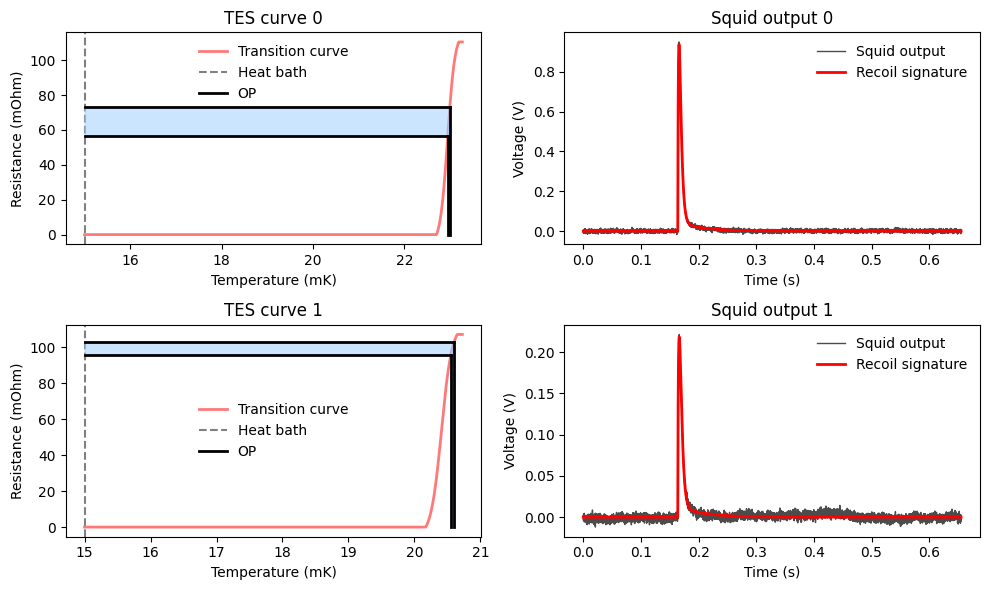

In [12]:
env.detector.plot_tes()

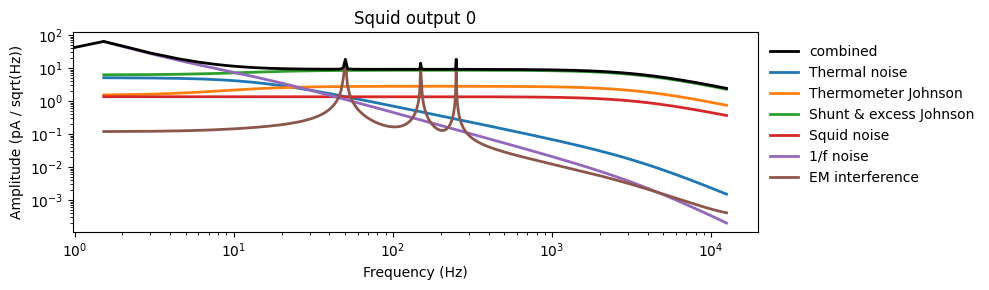

In [37]:
env.detector.plot_nps()

# training

In [9]:
obs, info = env.reset()

In [10]:
env.state  # PH, RMS, DAC, IB, TPA, CPE

array([-0.99988256, -0.99932319, -0.9999706 , -0.99984592,  0.58653533,
       -1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
       -0.99988556, -0.99942972])

In [11]:
# worked for bs = 8, grs = 5 after 16 60 step EPs, without sweep
# worked for bs = 16, grs = 20 after ~10 60 step EPs, without sweep
# higher noise, higher omega, already after 6 EPs

model = SoftActorCritic(env, policy = "GaussianPolicy", critic = "QNetwork", lr=3e-4, buffer_size=buffer_size, learning_starts=0,
                        batch_size=16, gamma=.99, gradient_steps=20, grad_clipping=.5, tau=0.005, 
                        device='cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
tracker = ReturnTracker()
writer = HistoryWriter()

In [13]:
env.launch_display(title='Training {} with {} TES'.format(name_load, env.ntes), 
                   color='red' if name_load == 'li1p' else 'turquoise' if name_load == 'li1l' else 'yellow' if name_load == 'li2p' else None)

FigureWidget({
    'data': [{'marker': {'color': 'turquoise'},
              'mode': 'lines',
              'name': 'Pulse TES 0',
              'type': 'scatter',
              'uid': '56f8a333-2243-4caf-a312-85624180bb89',
              'xaxis': 'x',
              'y': [0.0],
              'yaxis': 'y'},
             {'marker': {'color': 'turquoise'},
              'mode': 'lines',
              'name': 'PH TES 0',
              'type': 'scatter',
              'uid': 'a55cc516-99b6-4ccb-90ff-7f0233d163d5',
              'xaxis': 'x2',
              'y': [0.0],
              'yaxis': 'y2'},
             {'marker': {'color': 'turquoise'},
              'mode': 'lines',
              'name': 'DAC TES 0',
              'type': 'scatter',
              'uid': '39a824ea-2531-465d-827a-b7c58300119e',
              'xaxis': 'x3',
              'y': [0.0],
              'yaxis': 'y3'},
             {'marker': {'color': 'turquoise'},
              'mode': 'lines',
              'name': 'IB TE

In [14]:
# force the sweep

ops = generate_sweep(12,10)

state = obs

for dac,ib in tqdm(ops):
    action = [dac] * env.nheater
    action.extend([ib] * env.ntes)
    action = np.array(action)
    next_state, reward, terminated, truncated, info = model.env.step(action)
    model.buffer.store_transition(state, action, reward, next_state, terminated)
    state = next_state

  0%|          | 0/120 [00:00<?, ?it/s]

In [14]:
model.learn(episodes = 20, 
            episode_steps = 60, 
            two_pbars=True,
            tracker=tracker,
            writer=writer)

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 intdy--  t (=r1) illegal        
      in above message,  r1 =  0.4000244155527D-04
      t not in interval tcur - hu (= r1) to tcur (=r2)       
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 intdy--  t (=r1) illegal        
      in above message,  r1 =  0.8000488311054D-04
      t not in interval tcur - hu (= r1) to tcur (=r2)       
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 lsoda--  trouble from intdy. itask = i1, tout = r1  
      in above message,  i1 =         4
      in above message,  r1 =  0.8000488311054D-04


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [39]:
# save buffer

import os 

path_models = '{}{}_v{}/models/'.format(buffer_save_path, name_load, version)
path_data = '{}{}_v{}/data/'.format(buffer_save_path, name_load, version)

os.mkdir(path_models[:-8])
os.mkdir(path_models[:-1])
os.mkdir(path_data[:-1])


In [41]:
all_buffers = ['state_memory', 'next_state_memory', 'action_memory', 'reward_memory', 'terminal_memory', 'buffer_counter', 'buffer_total']
if hasattr(model.buffer, 'trajectory_idx'):
    all_buffers.append('trajectory_idx')

for name_buffer in all_buffers:
    np.save(path_data + name_buffer + '.npy', eval('model.buffer.{}'.format(name_buffer)))

In [42]:
model.save(path_models)

In [ ]:
import json
  
with open('{}{}_v{}/info.txt'.format(buffer_save_path, name_load, version), 'w') as fh:
     fh.write(json.dumps(aug_pars))

# buffer

In [12]:
# world_model.get_reward()

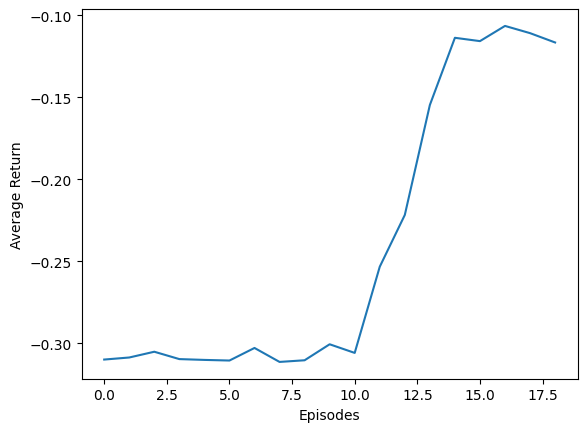

In [12]:
tracker.plot(smooth=1)

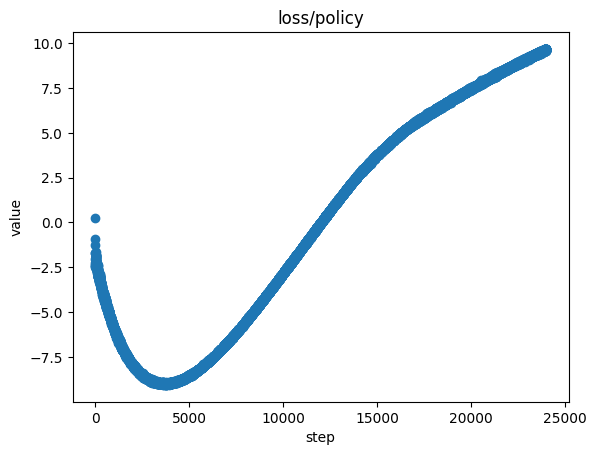

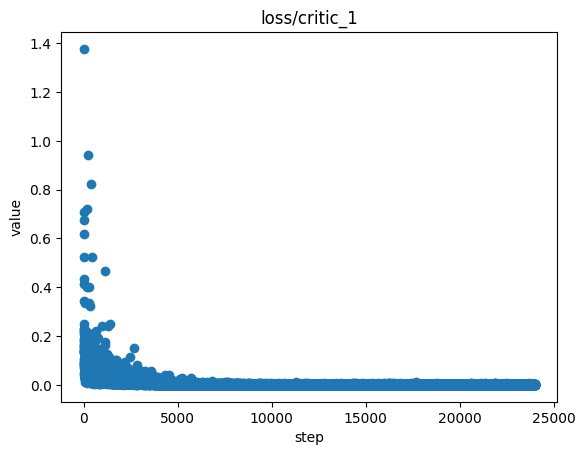

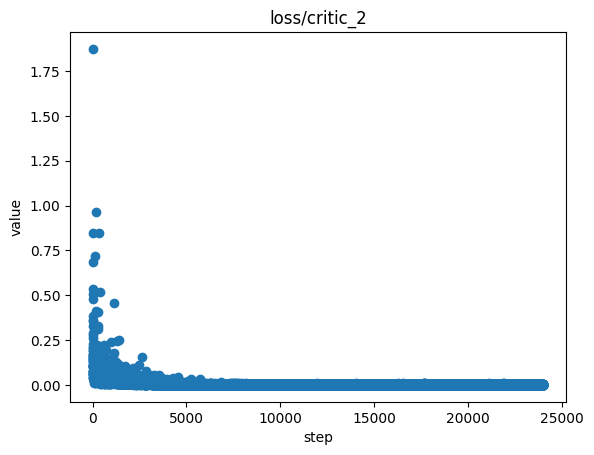

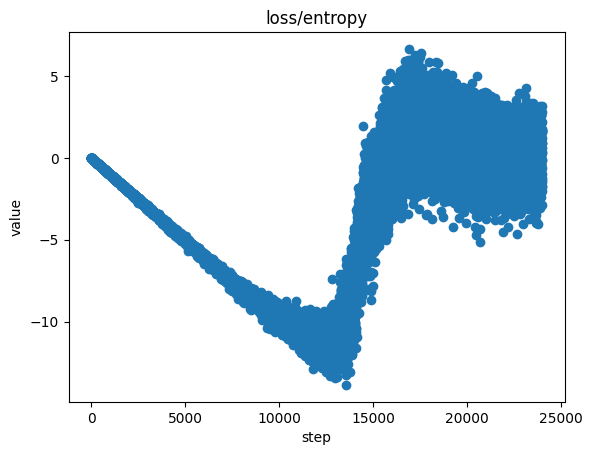

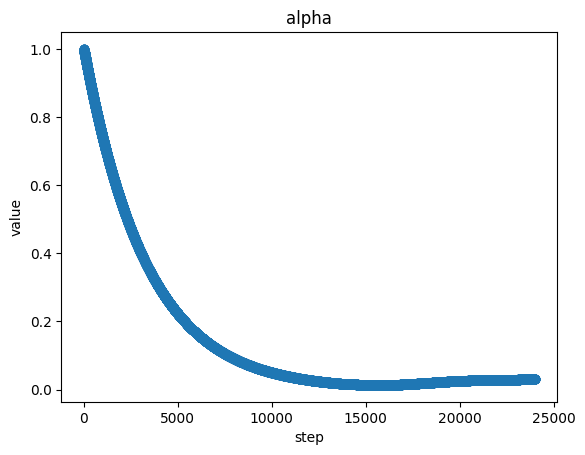

In [13]:
for key in writer.history.keys():
    writer.plot(key)

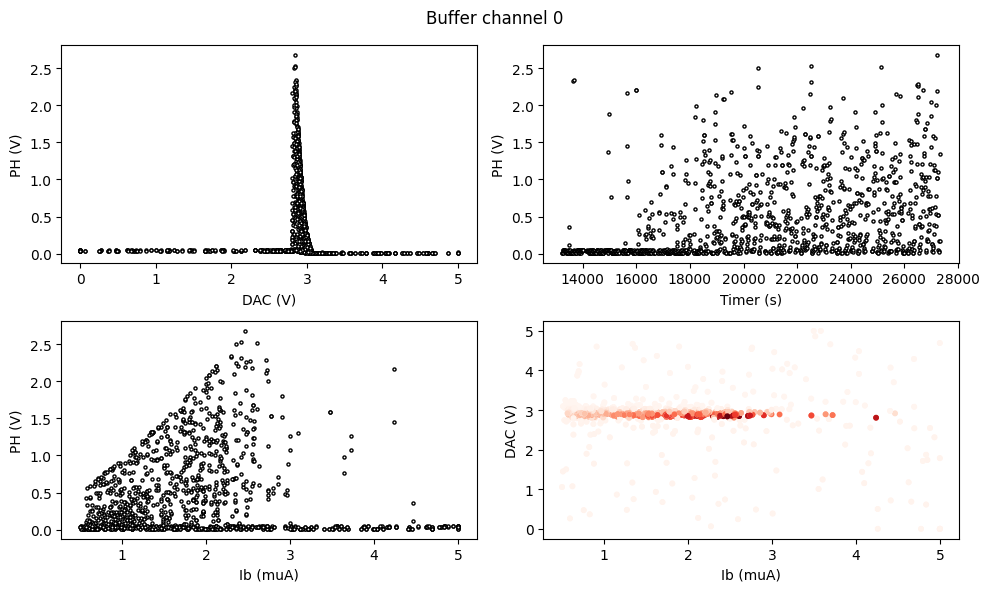

In [43]:
env.detector.plot_buffer(save_path=path_data + 'plot_buffer.png')

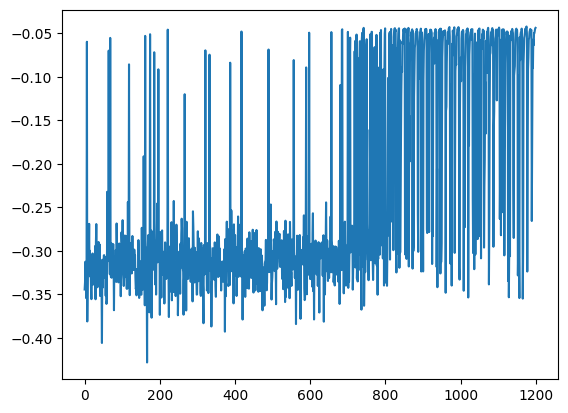

In [15]:
plt.plot(model.buffer.reward_memory[:1200])
# plt.ylim(-.01,0.001)

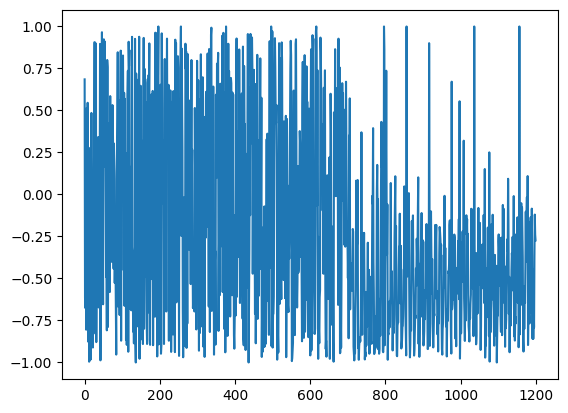

In [16]:
plt.plot(model.buffer.state_memory[:1200,2])

# inference

In [47]:
obs, _ = env.reset(clear_buffer=True)
model.policy.eval()
returns = 0
for i in trange(20):
    action, _ = model.predict(obs)
    obs, reward, terminated, truncated, info = env.step(action.flatten())
    print(action)
    print(obs, reward)
    returns += reward
    env.render()
    if terminated or truncated:
        obs, _ = env.reset()

  0%|          | 0/20 [00:00<?, ?it/s]

[[ 0.04087431 -0.1331653 ]]
[-0.99938494 -0.99983115 -0.13316536  0.04087436  1.         -0.99938555] -0.3343828208951812
[[ 0.15396969 -0.6499053 ]]
[-0.99902312 -0.99978688 -0.64990532  0.15396965 -0.98       -0.96359758] -0.30013807351225563
[[ 0.16006131 -0.7457877 ]]
[-0.99751443 -0.99975637 -0.74578768  0.16006136 -0.9        -0.96674736] -0.13673165694222664
[[ 0.1585213  -0.69693315]]
[-0.99582718 -0.99977841 -0.69693315  0.15852129 -0.8        -0.9660334 ] -0.09190843708651901
[[ 0.15791854 -0.67213696]]
[-0.99200067 -0.99979002 -0.6721369   0.15791857 -0.6        -0.96603947] -0.06530817255055703
[[ 0.15651411 -0.6099608 ]]
[-0.98844117 -0.99980822 -0.60996079  0.15651417 -0.4        -0.96568692] -0.055683551297383616
[[ 0.1543401 -0.5455609]]
[-0.98455173 -0.99982362 -0.5455609   0.15434015 -0.2        -0.96507465] -0.05049793961600528
[[ 0.15216748 -0.4699843 ]]
[-0.98073884 -0.99983946 -0.46998429  0.15216744  0.         -0.96457929] -0.04740729468632504
[[ 0.1503164  -0.3

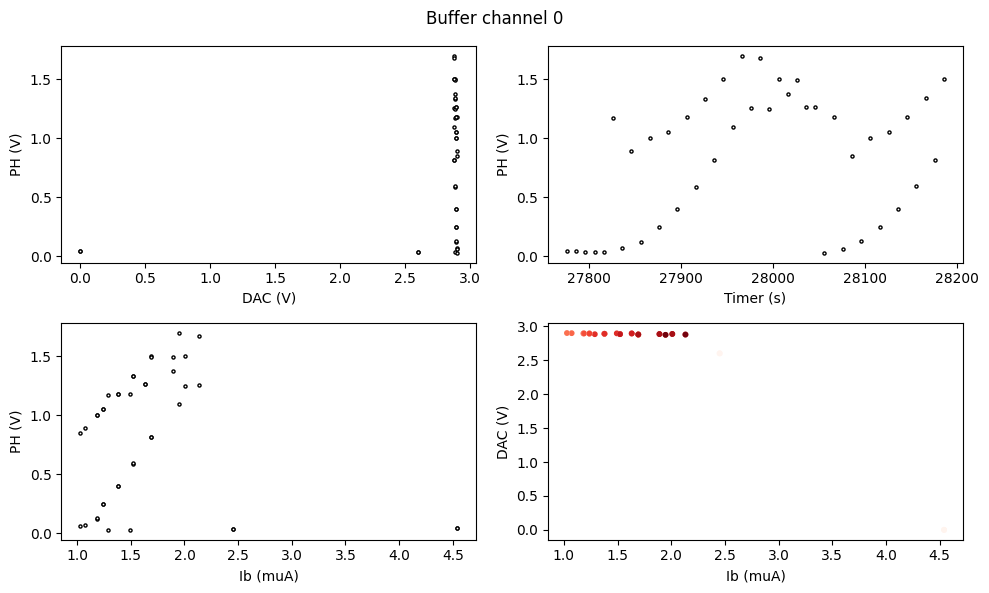

In [48]:
env.detector.plot_buffer()

In [23]:
# env.close()

# analyze policy

In [64]:
policy = model.policy
target_critic = model.target_critic

x = model.buffer.state_memory

idx_current = 1000
idx_max = 1001
idx_min = 1002

names = ['PH', 'RMS', 'IB', 'DAC', 'TPA', 'CPH']

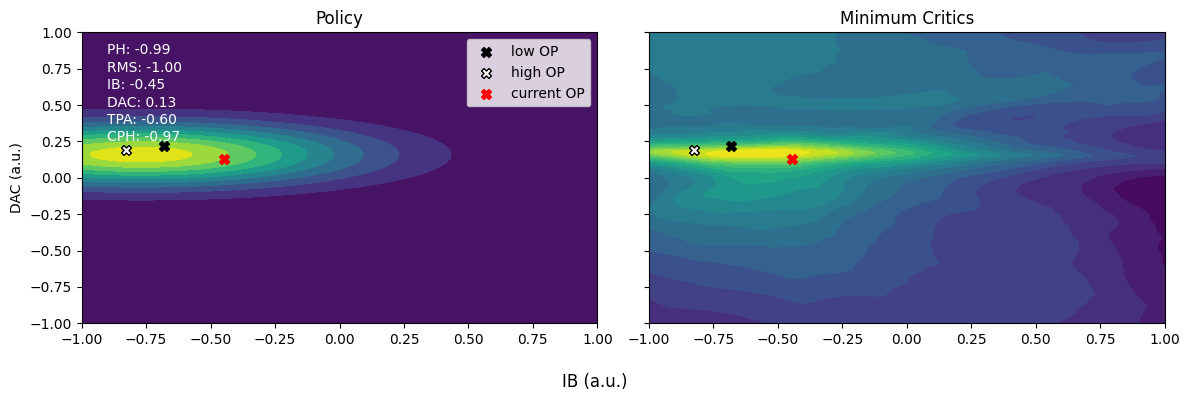

In [66]:
from scipy.stats import multivariate_normal

plot_scatter = True
min_critics = True 

obs = torch.tensor(x[idx_current], dtype=torch.float32).reshape(1, -1) 
# obs = torch.tensor([-1., -1., .369, -.38, .0]).reshape(1, -1)  # PH, RMS, IB, DAC, CPH
#obs[0,0] = -0.4
min_obs = torch.tensor(x[idx_min], dtype=torch.float32).reshape(1, -1) 
max_obs = torch.tensor(x[idx_max], dtype=torch.float32).reshape(1, -1) 

mu, log_std = policy(obs)
mu = mu.detach().numpy().flatten()
with torch.no_grad():
    log_std = log_std.numpy().flatten()

rv = multivariate_normal(mu, np.diag(np.exp(log_std)))

x_grid, y_grid = np.mgrid[-1:1.01:.01, -1:1.01:.01]
pos = np.dstack((x_grid, y_grid))


action = torch.tensor([[x_,y_] for x_,y_ in zip(x_grid.flatten(), y_grid.flatten())], dtype=torch.float32)  # , dtype=torch.float32

with torch.no_grad():
    val1, val2 = target_critic(torch.tile(obs, (40401,1)), action)
    val_min = torch.min(val1, val2)

fig, ax = plt.subplots(1,2 if min_critics else 3,dpi=100,figsize=(12,4), sharex=True, sharey=True)

ax[0].contourf(y_grid, x_grid, rv.pdf(pos), levels=10)  # IB, DAC
if plot_scatter:
    ax[0].scatter(min_obs[0,2], min_obs[0,3], color='black', edgecolor='black', s=100*(min_obs[0,0]+1) + 50, marker='X', label='low OP')
    ax[0].scatter(max_obs[0,2], max_obs[0,3], color='white', edgecolor='black', s=100*(max_obs[0,0]+1) + 50, marker='X', label='high OP')
    ax[0].scatter(obs[0,2], obs[0,3], color='red', s=100*(obs[0,0]+1) + 50, marker='X', label='current OP')
    ax[0].legend()

for i,n in enumerate(names):
    ax[0].text(-0.9, 0.85 - i*0.12, '{}: {:.2f}'.format(n, obs[0,i]), color='white')
ax[0].set_ylabel('DAC (a.u.)')
ax[0].set_title('Policy')
if not min_critics:
    ax[1].contourf(y_grid, x_grid, val1.reshape(201,201), levels=20)  # IB, DAC
    if plot_scatter:
        ax[1].scatter(min_obs[0,2], min_obs[0,3], color='black', edgecolor='black', s=100*(min_obs[0,0]+1) + 50, marker='X')
        ax[1].scatter(max_obs[0,2], max_obs[0,3], color='white', edgecolor='black', s=100*(max_obs[0,0]+1) + 50, marker='X')
        ax[1].scatter(obs[0,2], obs[0,3], color='red', s=100*(obs[0,0]+1) + 50, marker='X', label='current OP')
    ax[1].set_title('Critic 1')
    ax[2].contourf(y_grid, x_grid, val2.reshape(201,201), levels=20)  # IB, DAC
    if plot_scatter:
        ax[2].scatter(min_obs[0,2], min_obs[0,3], color='black', edgecolor='black', s=100*(min_obs[0,0]+1) + 50, marker='X')
        ax[2].scatter(max_obs[0,2], max_obs[0,3], color='white', edgecolor='black', s=100*(max_obs[0,0]+1) + 50, marker='X')
        ax[1].scatter(obs[0,2], obs[0,3], color='red', s=100*(obs[0,0]+1) + 50, marker='X', label='current OP')
    ax[2].set_title('Critic 2')
else:
    ax[1].contourf(y_grid, x_grid, val_min.reshape(201,201), levels=20)  # IB, DAC
    if plot_scatter:
        ax[1].scatter(min_obs[0,2], min_obs[0,3], color='black', edgecolor='black', s=100*(min_obs[0,0]+1) + 50, marker='X')
        ax[1].scatter(max_obs[0,2], max_obs[0,3], color='white', edgecolor='black', s=100*(max_obs[0,0]+1) + 50, marker='X')
        ax[1].scatter(obs[0,2], obs[0,3], color='red', s=100*(obs[0,0]+1) + 50, marker='X', label='current OP')
    ax[1].set_title('Minimum Critics')
    
plt.xlim(-1,1)
plt.ylim(-1,1)
fig.supxlabel('IB (a.u.)')
plt.tight_layout()
plt.show()